In [1]:
# Install required libraries
!pip install -U kaleido # for saving graphs

In [1]:
!pip install --upgrade plotly>=6.1.1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
# @title Filling missing values

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df

In [6]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [7]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature (TTF_Price)
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [29]:
# @title Defining evaluation matrics forecast_metrics

results_df = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date'])

def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, results_df=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<15} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Append row to DataFrame
    if results_df is not None:
        results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date]

    return results_df

In [9]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'TTF_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['TTF_Price'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='TTF_Price (EUR/MWh)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [11]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")


In [12]:
#@title Function to Load Model and Training History
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and its training history.

    Parameters:
    - save_dir: directory path
    - model_name: base name used when saving

    Returns:
    - model: loaded Keras model
    - history: training history (as a dict)
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)

    # Load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    print(f"✅ Model loaded from: {model_path}")
    print(f"✅ History loaded from: {history_path}")
    return model, history


In [13]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

## Load data

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Price_inv_stor_LNG_water_pipe_TTFMc_raw_FIXED.xlsx'

In [16]:
# Load and prepare data
df_all = pd.read_excel(data_path + file_path)
df_all.head()

Date  PSV_Price  Brent_Price  TTF_Futures_Price  PVB_Price  JKM_Price  \
0 2009-01-01        NaN          NaN                NaN        NaN        NaN   
1 2009-01-02        NaN        46.91                NaN        NaN        NaN   
2 2009-01-03        NaN          NaN                NaN        NaN        NaN   
3 2009-01-04        NaN          NaN                NaN        NaN        NaN   
4 2009-01-05        NaN        49.62                NaN        NaN        NaN   

   NBP_Price  CBOE_Price  Coal_Price  HH_Price  ...  TTFMc4_Ask  TTFMc5_Close  \
0        NaN         NaN         NaN       NaN  ...       17.98           NaN   
1        NaN       39.19       74.35      5.41  ...       17.15           NaN   
2        NaN         NaN         NaN       NaN  ...         NaN           NaN   
3        NaN         NaN         NaN       NaN  ...         NaN           NaN   
4        NaN       39.08       77.65      5.83  ...       17.79           NaN   

   TTFMc6_Close  TTFMc6_OI  TTFMc7_Close  TTFMc7_OI  TTFMc8_Close  TTFMc8_OI  \
0           NaN        NaN           NaN        NaN           NaN        NaN   
1           NaN        NaN           NaN        NaN           NaN        NaN   
2           NaN        NaN           NaN        NaN           NaN        NaN   
3           NaN        NaN           NaN        NaN           NaN        NaN   
4           NaN        NaN           NaN        NaN           NaN        NaN   

   TTFMc9_Close  TTFMc9_OI  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  

[5 rows x 75 columns]

In [17]:
df_all.columns

Index(['Date', 'PSV_Price', 'Brent_Price', 'TTF_Futures_Price', 'PVB_Price',
       'JKM_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'Brent_Volume', 'TTF_Futures_Volume', 'Coal_Volume',
       'Temp_Global', 'Temp_Southern_Hemisphere', 'Temp_Northern_Hemisphere',
       'NetImports_Total', 'Inventories_Global', 'pipe_Norway', 'pipe_Algeria',
       'pipe_Russia', 'pipe_Azerbaijan', 'pipe_Libya', 'pipe_UK net flows',
       'pipe_LNG', 'pipe_EU total', 'pipe_Nord Stream',
       'pipe_Ukraine Gas Transit', 'pipe_Yamal (BY,PL)', 'pipe_Turkstream',
       'LNG_on_water_Asia', 'LNG_on_water_Unknown', 'LNG_on_water_Africa',
       'LNG_on_water_Europe', 'LNG_on_water_Americas',
       'floating_storages_Asia', 'floating_storages_Unknown',
       'floating_storages_Africa', 'floating_storages_Europe',
       'floating_storages_Americas', 'LNG_Freight_Price ($/day)',
       'TTFMc1_Close', 'TTFMc1_Open', 'TTFMc1_Low', 'TTFMc1_High',
       'TTFMc1_Bid', 'T

In [18]:
# Columns to plot
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['Brent_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'NBP_Price', 'PSV_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))

In [23]:
df_ttf = df_all[['Date','TTF_Price']].copy()
df_ttf = fill_missing_dates(df_ttf, date_column = 'Date')
df_ttf.head()

TTF_Price
Date                 
2009-01-01  21.000000
2009-01-02  22.200000
2009-01-03  22.416667
2009-01-04  22.633333
2009-01-05  22.850000

In [34]:
df_ttf.tail(10)

TTF_Price
Date                 
2025-07-03      40.03
2025-07-04      40.03
2025-07-05      40.03
2025-07-06      40.03
2025-07-07      40.03
2025-07-08      40.03
2025-07-09      40.03
2025-07-10      40.03
2025-07-11      40.03
2025-07-12      40.03

In [24]:
df_ttf1 = df_ttf.copy()

# Only define and apply smoothing in the volatile window
cap_start, cap_end = '2021-09-01', '2023-03-31'

# Backup original
df_ttf1['TTF_Price_Original'] = df_ttf1['TTF_Price']

# Cap extremes in the selected period
volatility_section = df_ttf1.loc[cap_start:cap_end, 'TTF_Price']
cap_threshold = volatility_section.quantile(0.70)

df_ttf1.loc[cap_start:cap_end, 'TTF_Price'] = np.minimum(
    df_ttf1.loc[cap_start:cap_end, 'TTF_Price'],
    cap_threshold
)

# Apply smoothing via rolling median on the capped section
smoothed_section = df_ttf1.loc[cap_start:cap_end, 'TTF_Price'].rolling(window=2, center=True).median()
smoothed_section = smoothed_section.fillna(method='bfill').fillna(method='ffill')

# Store result in a separate column
df_ttf1['TTF_Price_Smoothed'] = df_ttf1['TTF_Price_Original']
df_ttf1.loc[cap_start:cap_end, 'TTF_Price_Smoothed'] = smoothed_section

# Create Plotly figure
fig = go.Figure()

# Plot original TTF price
fig.add_trace(go.Scatter(
    x=df_ttf1.index,
    y=df_ttf1['TTF_Price_Original'],
    mode='lines',
    name='Original',
    line=dict(color='gray', width=1),
    opacity=0.5
))

# Plot smoothed TTF price
fig.add_trace(go.Scatter(
    x=df_ttf1.index,
    y=df_ttf1['TTF_Price_Smoothed'],
    mode='lines',
    name='Smoothed',
    line=dict(color='orange', width=2)
))

# Add shaded region for the capped/smoothed window
fig.add_vrect(
    x0=cap_start, x1=cap_end,
    fillcolor='lightgray', opacity=0.3,
    layer='below', line_width=0,
    annotation_text="Volatile Period", annotation_position="top left"
)

# Customize layout
fig.update_layout(
    title='TTF Price - Selective Smoothing of Volatile Period (2021–2022)',
    xaxis_title='Date',
    yaxis_title='TTF Price (EUR/MWh)',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99),
    height=600
)

# Show figure
fig.show()


/tmp/ipython-input-24-610914299.py:20: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [32]:
df_ttf1.loc[cap_start:cap_end, ['TTF_Price_Original', 'TTF_Price_Smoothed']].tail(10)

TTF_Price_Original  TTF_Price_Smoothed
Date                                              
2023-03-22               39.60              40.200
2023-03-23               42.50              41.050
2023-03-24               42.50              42.500
2023-03-25               42.75              42.625
2023-03-26               43.00              42.875
2023-03-27               43.25              43.125
2023-03-28               42.22              42.735
2023-03-29               42.85              42.535
2023-03-30               42.85              42.850
2023-03-31               47.25              45.050

# Try using Soft Capping the TTF price and fit the LSTM model to see if this helps

In [26]:
# -----------------------------
# Soft Capping Function
# -----------------------------
def soft_cap(series, threshold, scale=0.1):
    return np.where(series > threshold, threshold + (series - threshold) * scale, series)

# -----------------------------
# Apply Soft Capping
# -----------------------------
df_ttf_soft = df_ttf.copy()
cap_start, cap_end = '2021-09-01', '2023-03-31'
df_ttf_soft['TTF_Price_Original'] = df_ttf_soft['TTF_Price']

# Compute threshold from the volatile period
volatility_section = df_ttf1.loc[cap_start:cap_end, 'TTF_Price']
cap_threshold = volatility_section.quantile(0.80)

# Apply soft capping to only the volatile period
df_ttf_soft['TTF_Price_SoftCapped'] = df_ttf_soft['TTF_Price_Original']
df_ttf_soft.loc[cap_start:cap_end, 'TTF_Price_SoftCapped'] = soft_cap(
    df_ttf_soft.loc[cap_start:cap_end, 'TTF_Price_Original'],
    threshold=cap_threshold,
    scale=0.1  # Reduce spikes by 90%
)

# Create Plotly figure
fig = go.Figure()

# Plot original TTF price
fig.add_trace(go.Scatter(
    x=df_ttf_soft.index,
    y=df_ttf_soft['TTF_Price_Original'],
    mode='lines',
    name='Original',
    line=dict(color='gray', width=1),
    opacity=0.5
))

# Plot smoothed TTF price
fig.add_trace(go.Scatter(
    x=df_ttf_soft.index,
    y=df_ttf_soft['TTF_Price_SoftCapped'],
    mode='lines',
    name='Smoothed',
    line=dict(color='orange', width=2)
))

# Add shaded region for the capped/smoothed window
fig.add_vrect(
    x0=cap_start, x1=cap_end,
    fillcolor='lightgray', opacity=0.3,
    layer='below', line_width=0,
    annotation_text="Volatile Period", annotation_position="top left"
)

# Customize layout
fig.update_layout(
    title='TTF Price - Selective Smoothing of Volatile Period (2021–2022)',
    xaxis_title='Date',
    yaxis_title='TTF Price (EUR/MWh)',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99),
    height=600
)

# Show figure
fig.show()

In [27]:
# Step 1: Scale softcapped price
scaler = MinMaxScaler()
df_ttf_soft['SoftCapped_scaled'] = scaler.fit_transform(df_ttf_soft[['TTF_Price_SoftCapped']])
scaled = df_ttf_soft['SoftCapped_scaled'].values.reshape(-1, 1)

# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_ttf_soft.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences(scaled_test, window_size=window_size, horizon=horizon_days)


# Build and Train the LSTM Model

# Build model
model_base_softcaped = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])

model_base_softcaped.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_base_softcaped = model_base_softcaped.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0051 - mae: 0.0396 - mape: 7204.4551 - rmse: 0.0662 - val_loss: 0.0705 - val_mae: 0.2148 - val_mape: 41.6284 - val_rmse: 0.2655 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0014 - mae: 0.0216 - mape: 3274.2266 - rmse: 0.0374 - val_loss: 0.0514 - val_mae: 0.1774 - val_mape: 33.7160 - val_rmse: 0.2268 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0012 - mae: 0.0197 - mape: 2325.3921 - rmse: 0.0342 - val_loss: 0.0574 - val_mae: 0.1896 - val_mape: 36.6609 - val_rmse: 0.2396 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012 - mae: 0.0194 - mape: 14332.2471 - rmse: 0.0343 - val_loss: 0.0553 - val_mae: 0.1856 - val_mape: 36.0503 - val_rmse: 0.2352 - learning_rate: 0.0010
Epoch 5/50
135/136 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - mae: 0.0195 - mape: 319.2675 - rmse: 0.0331
Epoch 5: ReduceLROnPlatea

In [38]:
def print_train_test_shapes(X_train, X_test, y_train, y_test):
  print(f'X_train shape: {X_train.shape}')
  print(f'X_test shape: {X_test.shape}')
  print(f'y_train shape: {y_train.shape}')
  print(f'y_test shape: {y_test.shape}')

In [40]:
print_train_test_shapes(X_train, X_test, y_train, y_test)

X_train shape: (4809, 365, 1)
X_test shape: (834, 365, 1)
y_train shape: (4809, 1)
y_test shape: (834, 1)


In [30]:
# Step 1: Predict in scaled space
y_pred_scaled = model_base_softcaped.predict(X_test)

# Step 2: Inverse MinMax scaling
y_pred_softcaped = scaler.inverse_transform(y_pred_scaled)
y_test_softcaped = scaler.inverse_transform(y_test.reshape(-1, 1))

evaluation_metrics(y_test_softcaped, y_pred_softcaped, label='softcaped_prediction_single_featureLSTM',cutoff_date = '2023-03-31', results_df = results_df )

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
softcaped_prediction_single_featureLSTM | MAE:  5.109  MSE: 40.718  RMSE:  6.381  R²:  0.180


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   

         R2 cutoff_date  
0  0.179699  2023-03-31

# Try using log transform the TTF price and fit the LSTM model to see if this helps

In [35]:
# -----------------------------
# Apply Log Transformation
# -----------------------------
df_ttf_log = df_ttf.copy()
cap_start, cap_end = '2021-09-01', '2023-03-31'


# Apply log1p to entire series
df_ttf_log['TTF_Price_Log'] = np.log1p(df_ttf_log['TTF_Price'])

# Plot original and log-transformed in separate subplots
import plotly.subplots as sp

fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True,
                       vertical_spacing=0.05,
                       subplot_titles=("Original TTF Price", "Log-Transformed TTF Price"))

# Original
fig.add_trace(go.Scatter(
    x=df_ttf_log.index,
    y=df_ttf_log['TTF_Price'],
    name='Original',
    line=dict(color='gray', width=1)
), row=1, col=1)

# Log-transformed
fig.add_trace(go.Scatter(
    x=df_ttf_log.index,
    y=df_ttf_log['TTF_Price_Log'],
    name='Log-Transformed',
    line=dict(color='blue', width=2)
), row=2, col=1)

# Highlight volatile period
fig.add_vrect(x0=cap_start, x1=cap_end, fillcolor="lightgray", opacity=0.3, line_width=0, row=1, col=1)
fig.add_vrect(x0=cap_start, x1=cap_end, fillcolor="lightgray", opacity=0.3, line_width=0, row=2, col=1)

# Layout
fig.update_layout(
    title='TTF Price – Original vs Log-Transformed',
    height=600,
    hovermode='x unified',
    showlegend=False
)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Price (EUR/MWh)", row=1, col=1)
fig.update_yaxes(title_text="log(1 + Price)", row=2, col=1)

fig.show()

In [36]:
df_ttf_log.head()

TTF_Price  TTF_Price_Log
Date                                
2009-01-01  21.000000       3.091042
2009-01-02  22.200000       3.144152
2009-01-03  22.416667       3.153448
2009-01-04  22.633333       3.162658
2009-01-05  22.850000       3.171784

In [41]:
# Step 1: Scale log-transformed price
scaler = MinMaxScaler()
df_ttf_log['log_price_scaled'] = scaler.fit_transform(df_ttf_log[['TTF_Price_Log']])
scaled = df_ttf_log['log_price_scaled'].values.reshape(-1, 1)

# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_ttf_log.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences(scaled_test, window_size=window_size, horizon=horizon_days)

print_train_test_shapes(X_train, X_test, y_train, y_test)

X_train shape: (4809, 365, 1)
X_test shape: (834, 365, 1)
y_train shape: (4809, 1)
y_test shape: (834, 1)


In [42]:
# Build and Train the LSTM Model

# Build model
model_base_log = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])

model_base_log.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_base_log = model_base_log.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0284 - mae: 0.1076 - mape: 41949.5703 - rmse: 0.1521 - val_loss: 0.0149 - val_mae: 0.0896 - val_mape: 12.3348 - val_rmse: 0.1219 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0012 - mae: 0.0253 - mape: 23659.7930 - rmse: 0.0346 - val_loss: 0.0181 - val_mae: 0.1039 - val_mape: 15.2637 - val_rmse: 0.1346 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012 - mae: 0.0254 - mape: 14392.5801 - rmse: 0.0346 - val_loss: 0.0182 - val_mae: 0.1041 - val_mape: 15.3038 - val_rmse: 0.1350 - learning_rate: 0.0010
Epoch 4/50
134/136 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - mae: 0.0259 - mape: 5053.5986 - rmse: 0.0350
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012 - mae: 0.0258 - mape: 5753.4087 - rmse: 0.0350 - val_loss: 0.0179 - val_mae: 0.1023 - val_mape: 14.9305 

In [43]:
def inverse_log_scaled(scaled_values, scaler, max_log=700):
    log_values = scaler.inverse_transform(scaled_values)
    log_values_clipped = np.clip(log_values, a_min=None, a_max=max_log)
    return np.expm1(log_values_clipped)

In [44]:
def inverse_log_scaled_safe(scaled_values, scaler, max_log=700):
    """
    Safely inverse-transform log-scaled predictions.
    Prevents overflow when applying expm1.
    """
    # Step 1: Inverse scale
    log_vals = scaler.inverse_transform(scaled_values.reshape(-1, 1))

    # Step 2: Check and clip before expm1
    log_vals_clipped = np.clip(log_vals, a_min=None, a_max=max_log)

    # Step 3: Inverse log1p
    price_vals = np.expm1(log_vals_clipped)

    return price_vals

In [45]:
# Predict in log-scaled space
y_pred_log_scaled = model_base_log.predict(X_test)

# Step 1: Inverse MinMaxScaler
y_pred_log = scaler.inverse_transform(y_pred_log_scaled.reshape(-1, 1))
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 2: Clip in log space before expm1 to avoid overflow
y_pred_log_clipped = np.clip(y_pred_log, a_min=None, a_max=100)
y_test_log_clipped = np.clip(y_test_log, a_min=None, a_max=100)

# Step 3: Inverse log1p
y_pred_price = np.expm1(y_pred_log_clipped)
y_test_price = np.expm1(y_test_log_clipped)

# Step 4: Clip final prices to realistic range (optional)
y_pred_price = np.clip(y_pred_price, 0, 1000).astype(np.float64)
y_test_price = np.clip(y_test_price, 0, 1000).astype(np.float64)

# Step 5: Evaluate
mae = mean_absolute_error(y_test_price, y_pred_price)
mse = mean_squared_error(y_test_price, y_pred_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_price, y_pred_price)

print(f"Log-Transformed LSTM | MAE: {mae:.3f}  MSE: {mse:.3f}  RMSE: {rmse:.3f}  R²:  {r2:.3f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Log-Transformed LSTM | MAE: 5.573  MSE: 43.940  RMSE: 6.629  R²:  0.115


In [46]:
evaluation_metrics(y_test_price, y_pred_price, label='log_prediction_single_featureLSTM', cutoff_date = '2023-03-31', results_df = results_df)

log_prediction_single_featureLSTM | MAE:  5.573  MSE: 43.940  RMSE:  6.629  R²:  0.115


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31

# Try adding regime/stress flags on top of ttf price

In [49]:
df_ttf = df_all[['Date','TTF_Price']].copy()
df_ttf = fill_missing_dates(df_ttf, date_column= 'Date')

In [50]:
df_ttf.isna().sum()

TTF_Price    0
dtype: int64

In [51]:
df_ttf_stress = df_ttf.copy()
df_ttf_stress['stress_flag'] = 0
df_ttf_stress.loc['2021-09-01':'2023-03-31', 'stress_flag'] = 1  # or your chosen window
df_ttf_stress

TTF_Price  stress_flag
Date                              
2009-01-01  21.000000            0
2009-01-02  22.200000            0
2009-01-03  22.416667            0
2009-01-04  22.633333            0
2009-01-05  22.850000            0
...               ...          ...
2025-07-08  40.030000            0
2025-07-09  40.030000            0
2025-07-10  40.030000            0
2025-07-11  40.030000            0
2025-07-12  40.030000            0

[6037 rows x 2 columns]

In [52]:
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_ttf_stress[['TTF_Price', 'stress_flag']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_ttf_stress.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


# Build and Train the LSTM Model

# Build model
model_base_stress = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])

model_base_stress.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_base_stress = model_base_stress.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.5423e-04 - mae: 0.0176 - mape: 10872.1055 - rmse: 0.0262 - val_loss: 0.0321 - val_mae: 0.1423 - val_mape: 58.8168 - val_rmse: 0.1791 - learning_rate: 0.0010
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.3823e-04 - mae: 0.0072 - mape: 401.5511 - rmse: 0.0117 - val_loss: 0.0340 - val_mae: 0.1366 - val_mape: 51.3892 - val_rmse: 0.1845 - learning_rate: 0.0010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4133e-04 - mae: 0.0078 - mape: 334.2973 - rmse: 0.0119 - val_loss: 0.0389 - val_mae: 0.1488 - val_mape: 62.0245 - val_rmse: 0.1971 - learning_rate: 0.0010
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3237e-04 - mae: 0.0074 - mape: 3135.3530 - rmse: 0.0115
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.3241e-04 - mae: 0.0074 - mape: 3131.8232 - rmse: 0.0115 - val_loss: 0.4904 - val_mae: 0.4862 - va

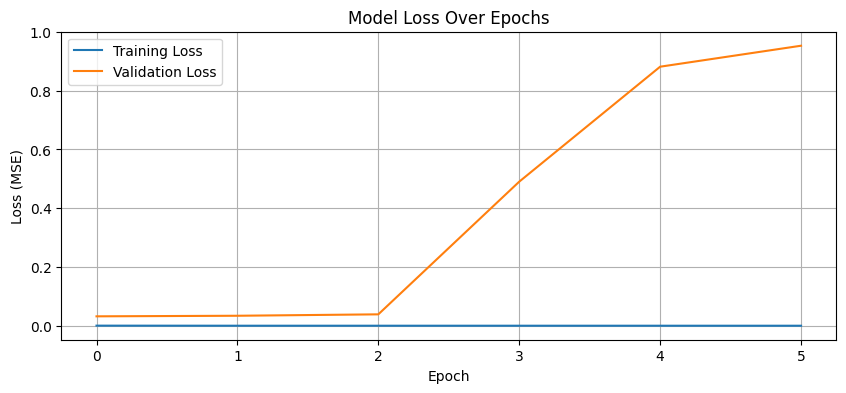

In [53]:
plot_loss(history_base_stress)

In [54]:
# After model prediction (in scaled space)
y_pred_scaled = model_base_stress.predict(X_test)

# Inverse just the price component
y_pred_stress = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=2)
y_test_stress = inverse_single_feature(scaler, y_test, feature_index=0, total_features=2)

evaluation_metrics(y_test_stress,y_pred_stress, label='model_base_stress', cutoff_date = '2023-03-31', results_df = results_df)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
model_base_stress | MAE:  5.989  MSE: 60.057  RMSE:  7.750  R²: -0.210


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31

In [58]:
df_multi_features = df_all[['Date','Brent_Price',
        'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close']].copy()

df_multi_features

Date  Brent_Price  NBP_Price  CBOE_Price  Coal_Price  HH_Price  \
0    2009-01-01          NaN        NaN         NaN         NaN       NaN   
1    2009-01-02        46.91        NaN       39.19       74.35      5.41   
2    2009-01-03          NaN        NaN         NaN         NaN       NaN   
3    2009-01-04          NaN        NaN         NaN         NaN       NaN   
4    2009-01-05        49.62        NaN       39.08       77.65      5.83   
...         ...          ...        ...         ...         ...       ...   
6032 2025-07-08          NaN        NaN         NaN         NaN       NaN   
6033 2025-07-09          NaN        NaN         NaN         NaN       NaN   
6034 2025-07-10          NaN        NaN         NaN         NaN       NaN   
6035 2025-07-11          NaN        NaN         NaN         NaN       NaN   
6036 2025-07-12          NaN        NaN         NaN         NaN       NaN   

      TTF_Price  TTFMc1_Close  
0         21.00         21.45  
1         22.20         20.15  
2           NaN           NaN  
3           NaN           NaN  
4         22.85         20.75  
...         ...           ...  
6032        NaN         34.58  
6033        NaN         34.38  
6034        NaN         35.20  
6035        NaN         35.61  
6036        NaN           NaN  

[6037 rows x 8 columns]

In [59]:
df_multi_features.isna().sum()

Date               0
Brent_Price     1772
NBP_Price       1949
CBOE_Price      1848
Coal_Price      1804
HH_Price        1875
TTF_Price       1791
TTFMc1_Close    1778
dtype: int64

In [60]:
df_multi_features = fill_missing_dates(df_multi_features, date_column= 'Date')
df_multi_features.isna().sum()


Brent_Price       1
NBP_Price       214
CBOE_Price        1
Coal_Price        1
HH_Price          1
TTF_Price         0
TTFMc1_Close      0
dtype: int64

In [61]:
df_multi_features.head(10)

Brent_Price  NBP_Price  CBOE_Price  Coal_Price  HH_Price  \
Date                                                                   
2009-01-01          NaN        NaN         NaN         NaN       NaN   
2009-01-02    46.910000        NaN   39.190000   74.350000  5.410000   
2009-01-03    47.813333        NaN   39.153333   75.450000  5.550000   
2009-01-04    48.716667        NaN   39.116667   76.550000  5.690000   
2009-01-05    49.620000        NaN   39.080000   77.650000  5.830000   
2009-01-06    50.530000        NaN   38.560000   81.250000  6.100000   
2009-01-07    45.860000        NaN   43.390000   78.650000  5.890000   
2009-01-08    44.670000        NaN   42.560000   79.150000  5.960000   
2009-01-09    44.420000        NaN   42.820000   76.900000  5.600000   
2009-01-10    43.916667        NaN   43.826667   77.533333  5.596667   

            TTF_Price  TTFMc1_Close  
Date                                 
2009-01-01  21.000000     21.450000  
2009-01-02  22.200000     20.150000  
2009-01-03  22.416667     20.350000  
2009-01-04  22.633333     20.550000  
2009-01-05  22.850000     20.750000  
2009-01-06  26.000000     23.060000  
2009-01-07  26.330000     22.190000  
2009-01-08  31.750000     21.650000  
2009-01-09  28.250000     21.580000  
2009-01-10  27.116667     21.476667

Adding some technical features of TTF



*   pct_change() computes the percentage change from one time step to the next:If TTF price went from 50 to 55 → return = (55−50)/50 = 0.10 (i.e. +10%)
*   MA_7: For each day 𝑡 t, it computes the average of the current day and the previous 6 days
*   Volativity_30 gives you a 30-day rolling standard deviation of TTF_Price, which is a common measure of price volatility.

*   The Bollinger Width (often called Bollinger Band Width) is a volatility indicator derived from Bollinger Bands, which are used in financial analysis to assess price volatility. df['bollinger_width'] = 4 * std / mean







In [62]:
df_multi_features['month'] = df_multi_features.index.month  # Integer (1–12)
df_multi_features['sin_day'] = np.sin(2 * np.pi * df_multi_features.index.dayofyear / 365.25)
df_multi_features['cos_day'] = np.cos(2 * np.pi * df_multi_features.index.dayofyear / 365.25)
df_multi_features['TTF_Return'] = df_multi_features['TTF_Price'].pct_change()
df_multi_features['MA_7'] = df_multi_features['TTF_Price'].rolling(7).mean()
df_multi_features['Volatility_30'] = df_multi_features['TTF_Price'].rolling(30).std()
df_multi_features['return_30'] = df_multi_features['TTF_Price'].pct_change(30)

In [63]:
df_multi_features['rolling_std_30'] = df_multi_features['TTF_Price'].pct_change().rolling(30).std()
df_multi_features['z_score_30'] = (df_multi_features['TTF_Price'] - df_multi_features['TTF_Price'].rolling(30).mean()) / df_multi_features['TTF_Price'].rolling(30).std()
df_multi_features['bollinger_width'] = 4 * df_multi_features['TTF_Price'].rolling(30).std() / df_multi_features['TTF_Price'].rolling(30).mean()

In [64]:
df_multi_features.head()

Brent_Price  NBP_Price  CBOE_Price  Coal_Price  HH_Price  \
Date                                                                   
2009-01-01          NaN        NaN         NaN         NaN       NaN   
2009-01-02    46.910000        NaN   39.190000       74.35      5.41   
2009-01-03    47.813333        NaN   39.153333       75.45      5.55   
2009-01-04    48.716667        NaN   39.116667       76.55      5.69   
2009-01-05    49.620000        NaN   39.080000       77.65      5.83   

            TTF_Price  TTFMc1_Close  month   sin_day   cos_day  TTF_Return  \
Date                                                                         
2009-01-01  21.000000         21.45      1  0.017202  0.999852         NaN   
2009-01-02  22.200000         20.15      1  0.034398  0.999408    0.057143   
2009-01-03  22.416667         20.35      1  0.051584  0.998669    0.009760   
2009-01-04  22.633333         20.55      1  0.068755  0.997634    0.009665   
2009-01-05  22.850000         20.75      1  0.085906  0.996303    0.009573   

            MA_7  Volatility_30  return_30  rolling_std_30  z_score_30  \
Date                                                                     
2009-01-01   NaN            NaN        NaN             NaN         NaN   
2009-01-02   NaN            NaN        NaN             NaN         NaN   
2009-01-03   NaN            NaN        NaN             NaN         NaN   
2009-01-04   NaN            NaN        NaN             NaN         NaN   
2009-01-05   NaN            NaN        NaN             NaN         NaN   

            bollinger_width  
Date                         
2009-01-01              NaN  
2009-01-02              NaN  
2009-01-03              NaN  
2009-01-04              NaN  
2009-01-05              NaN

In [65]:
df_multi_features.dropna(inplace=True)
df_multi_features

Brent_Price  NBP_Price  CBOE_Price  Coal_Price  HH_Price  \
Date                                                                   
2009-08-03        73.55      20.25       25.56       70.63      3.43   
2009-08-04        74.28      22.90       24.89       73.75      3.53   
2009-08-05        75.51      22.50       24.90       73.65      3.61   
2009-08-06        74.83      23.55       25.67       74.25      3.78   
2009-08-07        73.59      23.25       24.76       74.05      3.57   
...                 ...        ...         ...         ...       ...   
2025-07-08        69.31      96.70       18.05      109.95      3.26   
2025-07-09        69.31      96.70       18.05      109.95      3.26   
2025-07-10        69.31      96.70       18.05      109.95      3.26   
2025-07-11        69.31      96.70       18.05      109.95      3.26   
2025-07-12        69.31      96.70       18.05      109.95      3.26   

            TTF_Price  TTFMc1_Close  month   sin_day   cos_day  TTF_Return  \
Date                                                                         
2009-08-03       8.85          9.00      8 -0.528581 -0.848883    0.000000   
2009-08-04       9.45          9.45      8 -0.543105 -0.839665    0.067797   
2009-08-05       9.25          9.37      8 -0.557468 -0.830198   -0.021164   
2009-08-06       9.25          9.58      8 -0.571667 -0.820486    0.000000   
2009-08-07       9.23          9.57      8 -0.585696 -0.810531   -0.002162   
...               ...           ...    ...       ...       ...         ...   
2025-07-08      40.03         34.58      7 -0.109446 -0.993993    0.000000   
2025-07-09      40.03         34.38      7 -0.126528 -0.991963    0.000000   
2025-07-10      40.03         35.20      7 -0.143572 -0.989640    0.000000   
2025-07-11      40.03         35.61      7 -0.160575 -0.987024    0.000000   
2025-07-12      40.03         35.61      7 -0.177529 -0.984116    0.000000   

                 MA_7  Volatility_30  return_30  rolling_std_30  z_score_30  \
Date                                                                          
2009-08-03   9.108571       0.641057  -0.169274        0.028780   -0.620677   
2009-08-04   9.101429       0.578863  -0.119018        0.031702    0.422668   
2009-08-05   9.075714       0.494673  -0.143519        0.031793    0.194741   
2009-08-06   9.050000       0.440770  -0.106280        0.031021    0.301744   
2009-08-07   9.104286       0.371743  -0.110790        0.031000    0.407091   
...               ...            ...        ...             ...         ...   
2025-07-08  40.030000       1.743147   0.127182        0.018543    0.538490   
2025-07-09  40.030000       1.598657   0.133031        0.018477    0.489161   
2025-07-10  40.030000       1.340872   0.156936        0.017889    0.448216   
2025-07-11  40.030000       1.140745   0.122232        0.017223    0.399446   
2025-07-12  40.030000       0.907365   0.115042        0.017232    0.350465   

            bollinger_width  
Date                         
2009-08-03         0.277277  
2009-08-04         0.251534  
2009-08-05         0.216164  
2009-08-06         0.193384  
2009-08-07         0.163787  
...                     ...  
2025-07-08         0.178367  
2025-07-09         0.162929  
2025-07-10         0.136029  
2025-07-11         0.115302  
2025-07-12         0.091395  

[5823 rows x 17 columns]

In [66]:
df_multi_features['Volatility_30'].sort_values(ascending=False).head(10)

Date
2022-03-09    53.283534
2022-03-08    53.131531
2022-03-10    52.975831
2022-03-11    52.567887
2022-09-22    52.483549
2022-09-20    52.364978
2022-09-21    52.329492
2022-09-19    51.988852
2022-03-12    51.945118
2022-09-23    51.438502
Name: Volatility_30, dtype: float64

In [67]:
df_multi_features.head(15)

Brent_Price  NBP_Price  CBOE_Price  Coal_Price  HH_Price  \
Date                                                                   
2009-08-03    73.550000  20.250000   25.560000   70.630000  3.430000   
2009-08-04    74.280000  22.900000   24.890000   73.750000  3.530000   
2009-08-05    75.510000  22.500000   24.900000   73.650000  3.610000   
2009-08-06    74.830000  23.550000   25.670000   74.250000  3.780000   
2009-08-07    73.590000  23.250000   24.760000   74.050000  3.570000   
2009-08-08    73.560000  23.066667   24.836667   73.983333  3.563333   
2009-08-09    73.530000  22.883333   24.913333   73.916667  3.556667   
2009-08-10    73.500000  22.700000   24.990000   73.850000  3.550000   
2009-08-11    72.460000  24.150000   25.990000   73.950000  3.540000   
2009-08-12    72.890000  23.800000   25.450000   73.950000  3.360000   
2009-08-13    73.480000  24.600000   24.710000   74.350000  3.340000   
2009-08-14    72.410000  24.000000   24.270000   73.650000  3.180000   
2009-08-15    71.786667  23.716667   25.476667   73.600000  3.156667   
2009-08-16    71.163333  23.433333   26.683333   73.550000  3.133333   
2009-08-17    70.540000  23.150000   27.890000   73.500000  3.110000   

            TTF_Price  TTFMc1_Close  month   sin_day   cos_day  TTF_Return  \
Date                                                                         
2009-08-03   8.850000      9.000000      8 -0.528581 -0.848883    0.000000   
2009-08-04   9.450000      9.450000      8 -0.543105 -0.839665    0.067797   
2009-08-05   9.250000      9.370000      8 -0.557468 -0.830198   -0.021164   
2009-08-06   9.250000      9.580000      8 -0.571667 -0.820486    0.000000   
2009-08-07   9.230000      9.570000      8 -0.585696 -0.810531   -0.002162   
2009-08-08   9.286667      9.626667      8 -0.599551 -0.800336    0.006139   
2009-08-09   9.343333      9.683333      8 -0.613230 -0.789905    0.006102   
2009-08-10   9.400000      9.740000      8 -0.626727 -0.779239    0.006065   
2009-08-11   9.650000      9.610000      8 -0.640038 -0.768343    0.026596   
2009-08-12   9.430000      9.670000      8 -0.653160 -0.757220   -0.022798   
2009-08-13   9.750000      9.720000      8 -0.666089 -0.745872    0.033934   
2009-08-14   9.400000      9.540000      8 -0.678820 -0.734304   -0.035897   
2009-08-15   9.283333      9.460000      8 -0.691351 -0.722519   -0.012411   
2009-08-16   9.166667      9.380000      8 -0.703677 -0.710520   -0.012567   
2009-08-17   9.050000      9.300000      8 -0.715795 -0.698310   -0.012727   

                MA_7  Volatility_30  return_30  rolling_std_30  z_score_30  \
Date                                                                         
2009-08-03  9.108571       0.641057  -0.169274        0.028780   -0.620677   
2009-08-04  9.101429       0.578863  -0.119018        0.031702    0.422668   
2009-08-05  9.075714       0.494673  -0.143519        0.031793    0.194741   
2009-08-06  9.050000       0.440770  -0.106280        0.031021    0.301744   
2009-08-07  9.104286       0.371743  -0.110790        0.031000    0.407091   
2009-08-08  9.166667       0.349920  -0.050443        0.029284    0.641417   
2009-08-09  9.237143       0.346368  -0.011287        0.028659    0.821863   
2009-08-10  9.315714       0.348399   0.007143        0.028582    0.973342   
2009-08-11  9.344286       0.363726   0.047016        0.028852    1.579946   
2009-08-12  9.370000       0.369442   0.036264        0.029087    0.930231   
2009-08-13  9.441429       0.388673   0.077348        0.029641    1.647485   
2009-08-14  9.465714       0.362900   0.128451        0.026340    0.701755   
2009-08-15  9.465238       0.352800   0.069508        0.025520    0.334152   
2009-08-16  9.440000       0.310692   0.107085        0.024005   -0.091194   
2009-08-17  9.390000       0.276825   0.073547        0.024026   -0.598452   

            bollinger_width  
Date                         
2009-08-03         0.277277  
2009-08-04         0.251534  
2009-08-05   

In [68]:
df_multi_features.columns

Index(['Brent_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width'],
      dtype='object')

# Recommended Approaches to Find Most Important Features
1️⃣ Train a Tree-Based Model (XGBoost/RandomForest)
This is the quickest and most interpretable approach:

<Axes: >

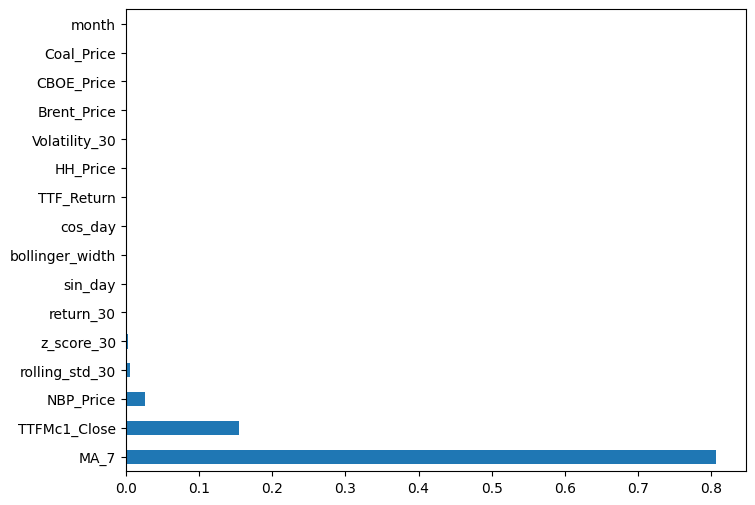

In [69]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Use same features & target as in LSTM
X = df_multi_features.drop(columns='TTF_Price')
y = df_multi_features['TTF_Price']

# Drop NaNs after rolling features
X, y = X.align(y, join='inner', axis=0)

model = XGBRegressor()
model.fit(X, y)

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8, 6))

In [71]:
#@title try all features and train the LSTM model

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['Brent_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print_train_test_shapes(X_train, X_test, y_train, y_test)


# Build and Train the LSTM Model

# Build model
model_17_features = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_17_features.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_17_features = model_17_features.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)


# After model prediction (in scaled space)
y_pred_scaled = model_17_features.predict(X_test)

# Inverse just the price component
y_pred_17_features = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=17)
y_test_17_features = inverse_single_feature(scaler, y_test, feature_index=0, total_features=17)

evaluation_metrics(y_test_17_features,y_pred_17_features, label = 'model_17_features', cutoff_date = '2023-03-31', results_df = results_df )

X_train shape: (4870, 90, 17)
X_test shape: (834, 90, 17)
y_train shape: (4870,)
y_test shape: (834,)
Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0912 - mae: 0.2090 - mape: 11508.3887 - rmse: 0.2798 - val_loss: 0.0074 - val_mae: 0.0715 - val_mape: 10.7309 - val_rmse: 0.0861 - learning_rate: 0.0010
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0105 - mae: 0.0788 - mape: 33566.0820 - rmse: 0.1024 - val_loss: 0.0106 - val_mae: 0.0830 - val_mape: 12.3203 - val_rmse: 0.1030 - learning_rate: 0.0010
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0085 - mae: 0.0709 - mape: 116540.3750 - rmse: 0.0921 - val_loss: 0.0128 - val_mae: 0.0938 - val_mape: 14.3839 - val_rmse: 0.1133 - learning_rate: 0.0010
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - mae: 0.0673 - mape: 25960.0234 - rmse: 0.0861
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0074 

Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31

X_train shape: (4870, 90, 11)
X_test shape: (834, 90, 11)
y_train shape: (4870,)
y_test shape: (834,)
Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0085 - mae: 0.0580 - mape: 5279.4624 - rmse: 0.0841 - val_loss: 0.0304 - val_mae: 0.1294 - val_mape: 47.6995 - val_rmse: 0.1743 - learning_rate: 0.0010
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.5101e-04 - mae: 0.0205 - mape: 756.1335 - rmse: 0.0274 - val_loss: 0.0327 - val_mae: 0.1354 - val_mape: 53.1606 - val_rmse: 0.1809 - learning_rate: 0.0010
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6512e-04 - mae: 0.0160 - mape: 8351.2764 - rmse: 0.0216 - val_loss: 0.0307 - val_mae: 0.1313 - val_mape: 50.7590 - val_rmse: 0.1753 - learning_rate: 0.0010
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.6316e-04 - mae: 0.0139 - mape: 3393.0178 - rmse: 0.0190 - val_loss: 0.0283 - val_mae: 0.1252 - val_mape: 47.1958 - val_rmse: 0.1681 - learning_rate: 0.0010
Epoch 5/50
137/137 ━━━━━━━━

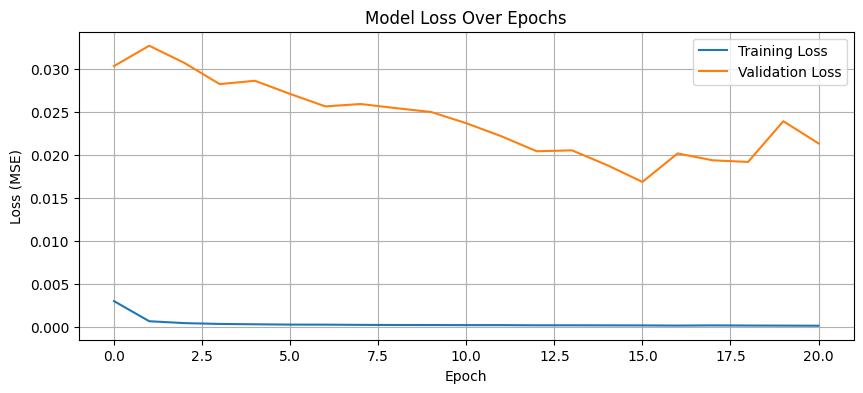

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
model_11feature_selected | MAE:  5.573  MSE: 43.940  RMSE:  6.629  R²:  0.115


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30

In [77]:
#@title try 11 selected features and train the LSTM model

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'TTFMc1_Close','MA_7', 'NBP_Price', 'rolling_std_30', 'z_score', 'Volatility_30',  , 'HH_Price', 'sin_day', 'cos_day',  'TTF_Return', 'Coal_Price']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print_train_test_shapes(X_train, X_test, y_train, y_test)

# Build and Train the LSTM Model

# Build model
model_11feature_selected = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_11feature_selected.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_11feature_selected = model_11feature_selected.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_11feature_selected)

# After model prediction (in scaled space)
y_pred_scaled = model_11feature_selected.predict(X_test)

# Inverse just the price component
y_pred_11feature_selected = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=11)
y_test_11feature_selected = inverse_single_feature(scaler, y_test, feature_index=0, total_features=11)

# save results
evaluation_metrics(y_test_price,y_pred_price, label = 'model_11feature_selected', cutoff_date = '2023-03-30', results_df = results_df )

In [78]:
#@title Selecting top 10 features
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'MA_7', 'NBP_Price', 'Volatility_30', 'TTFMc1_Close', 'rolling_std_30',
       'z_score_30', 'bollinger_width', 'sin_day', 'cos_day']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print_train_test_shapes(X_train, X_test, y_train, y_test)

# Build and Train the LSTM Model

# Build model
model_multi10 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi10.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi10 = model_multi10.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)



X_train shape: (4870, 90, 10)
X_test shape: (834, 90, 10)
y_train shape: (4870,)
y_test shape: (834,)
Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0036 - mae: 0.0415 - mape: 1306.9706 - rmse: 0.0574 - val_loss: 0.0307 - val_mae: 0.1252 - val_mape: 40.5696 - val_rmse: 0.1752 - learning_rate: 0.0010
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.6708e-04 - mae: 0.0156 - mape: 18804.3027 - rmse: 0.0216 - val_loss: 0.0279 - val_mae: 0.1226 - val_mape: 43.0452 - val_rmse: 0.1670 - learning_rate: 0.0010
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.4089e-04 - mae: 0.0131 - mape: 107.3674 - rmse: 0.0184 - val_loss: 0.0274 - val_mae: 0.1235 - val_mape: 45.3464 - val_rmse: 0.1655 - learning_rate: 0.0010
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.7764e-04 - mae: 0.0115 - mape: 307.6660 - rmse: 0.0167 - val_loss: 0.0261 - val_mae: 0.1225 - val_mape: 46.4595 - val_rmse: 0.1614 - learning_rate: 0.0010
Epoch 5/50
137/137 ━━━━━━━━

In [81]:

# After model prediction (in scaled space)
y_pred_scaled_multi10 = model_multi10.predict(X_test)

# Inverse just the price component
y_pred_multi10 = inverse_single_feature(scaler, y_pred_scaled_multi10, feature_index=0, total_features=10)
y_test_multi10 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=10)

evaluation_metrics(y_test_multi10,y_pred_multi10, label ='model_multi10', cutoff_date = '2023-03-31', results_df = results_df)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
model_multi10   | MAE:  5.576  MSE: 52.187  RMSE:  7.224  R²: -0.051


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   
5                            model_multi10  5.575670  52.187351  7.224081   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30  
5 -0.051350  2023-03-31

In [83]:
df_multi_features.columns

Index(['Brent_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width'],
      dtype='object')

X_train shape: (4595, 365, 7)
X_test shape: (834, 365, 7)
y_train shape: (4595,)
y_test shape: (834,)
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0011 - mae: 0.0216 - mape: 4503.3452 - rmse: 0.0326 - val_loss: 0.0450 - val_mae: 0.1707 - val_mape: 70.6165 - val_rmse: 0.2121 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.6467e-04 - mae: 0.0119 - mape: 264.6003 - rmse: 0.0191 - val_loss: 0.0426 - val_mae: 0.1642 - val_mape: 66.6230 - val_rmse: 0.2065 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1319e-04 - mae: 0.0106 - mape: 4360.7412 - rmse: 0.0176 - val_loss: 0.0463 - val_mae: 0.1737 - val_mape: 72.5955 - val_rmse: 0.2151 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 2.8814e-04 - mae: 0.0099 - mape: 1754.8126 - rmse: 0.0169 - val_loss: 0.0417 - val_mae: 0.1620 - val_mape: 65.7669 - val_rmse: 0.2041 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━

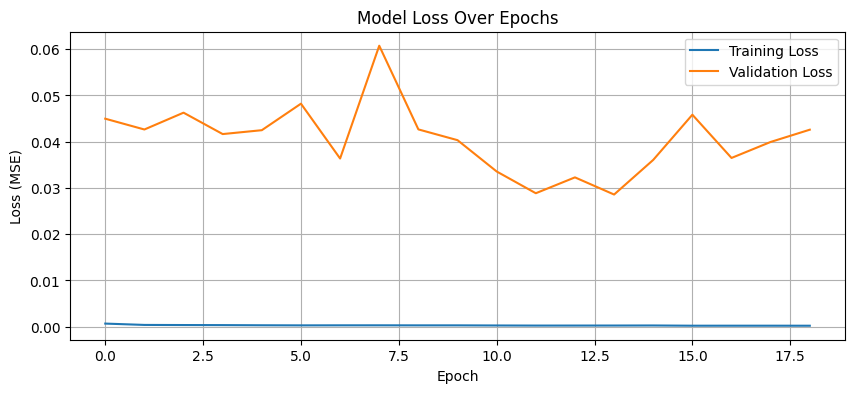

In [84]:
#@title Selecting top 7 features (window 365 instead of 90 as no month/cos/sin seasonality)
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'MA_7','NBP_Price', 'rolling_std_30','z_score_30', 'return_30', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi7 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi7.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_model_multi7 = model_multi7.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_model_multi7)


In [85]:
# After model prediction (in scaled space)
y_pred_scaled = model_multi7.predict(X_test)

# Inverse just the price component
y_pred_multi7 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=7)
y_test_multi7 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=7)

evaluation_metrics(y_test_multi7, y_pred_multi7, label = 'model_multi7', cutoff_date = '2023-03-31', results_df = results_df)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
model_multi7    | MAE:  5.690  MSE: 55.148  RMSE:  7.426  R²: -0.111


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   
5                            model_multi10  5.575670  52.187351  7.224081   
6                             model_multi7  5.690019  55.147832  7.426159   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30  
5 -0.051350  2023-03-31  
6 -0.110991  2023-03-31

In [86]:
df_multi_features.columns

Index(['Brent_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width'],
      dtype='object')

In [87]:
#@title selecting only TTF related features
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print_train_test_shapes(X_train, X_test, y_train, y_test)
# Build and Train the LSTM Model

# Build model
model_multi_ttf_related = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_ttf_related.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_ttf_related = model_multi_ttf_related.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)




X_train shape: (4870, 90, 12)
X_test shape: (834, 90, 12)
y_train shape: (4870,)
y_test shape: (834,)
Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0017 - mae: 0.0302 - mape: 20181.5898 - rmse: 0.0409 - val_loss: 0.0342 - val_mae: 0.1403 - val_mape: 59.7678 - val_rmse: 0.1849 - learning_rate: 0.0010
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 4.1504e-04 - mae: 0.0147 - mape: 5390.1636 - rmse: 0.0204 - val_loss: 0.0262 - val_mae: 0.1147 - val_mape: 41.1890 - val_rmse: 0.1620 - learning_rate: 0.0010
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9941e-04 - mae: 0.0115 - mape: 2874.5957 - rmse: 0.0172 - val_loss: 0.0226 - val_mae: 0.1106 - val_mape: 44.3436 - val_rmse: 0.1505 - learning_rate: 0.0010
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0422e-04 - mae: 0.0100 - mape: 3148.2905 - rmse: 0.0143 - val_loss: 0.0248 - val_mae: 0.1122 - val_mape: 34.9603 - val_rmse: 0.1576 - learning_rate: 0.0010
Epoch 5/50
137/137 ━━━━━━

In [89]:
# After model prediction (in scaled space)
y_pred_scaled = model_multi_ttf_related.predict(X_test)

# Inverse just the price component
y_pred_multi_ttf_related = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=12)
y_test_multi_ttf_related = inverse_single_feature(scaler, y_test, feature_index=0, total_features=12)

evaluation_metrics(y_test_multi_ttf_related, y_pred_multi_ttf_related, label = 'model_multi_ttf_related', cutoff_date = '2023-03-31', results_df = results_df)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
model_multi_ttf_related | MAE:  6.171  MSE: 60.695  RMSE:  7.791  R²: -0.223


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   
5                            model_multi10  5.575670  52.187351  7.224081   
6                             model_multi7  5.690019  55.147832  7.426159   
7                  model_multi_ttf_related  6.170526  60.695343  7.790722   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30  
5 -0.051350  2023-03-31  
6 -0.110991  2023-03-31  
7 -0.222750  2023-03-31

In [91]:
df_multi_features.columns

Index(['Brent_Price', 'NBP_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'TTFMc1_Close', 'month', 'sin_day', 'cos_day',
       'TTF_Return', 'MA_7', 'Volatility_30', 'return_30', 'rolling_std_30',
       'z_score_30', 'bollinger_width'],
      dtype='object')

In [92]:
#@title Selecting top4 features
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'MA_7', 'NBP_Price', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_top4 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_top4.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_top4 = model_multi_top4.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)



X_train shape: (4595, 365, 4)
X_test shape: (834, 365, 4)
y_train shape: (4595,)
y_test shape: (834,)
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.9698e-04 - mae: 0.0137 - mape: 2589.7314 - rmse: 0.0222 - val_loss: 0.0469 - val_mae: 0.1739 - val_mape: 73.7093 - val_rmse: 0.2166 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.5110e-04 - mae: 0.0110 - mape: 103.9597 - rmse: 0.0187 - val_loss: 0.0420 - val_mae: 0.1636 - val_mape: 67.1357 - val_rmse: 0.2048 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 3.1996e-04 - mae: 0.0098 - mape: 298.9748 - rmse: 0.0178 - val_loss: 0.0321 - val_mae: 0.1362 - val_mape: 48.3579 - val_rmse: 0.1791 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.2072e-04 - mae: 0.0099 - mape: 2693.2375 - rmse: 0.0179 - val_loss: 0.0333 - val_mae: 0.1414 - val_mape: 52.5883 - val_rmse: 0.1824 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━

In [94]:

# After model prediction (in scaled space)
y_pred_scaled = model_multi_top4.predict(X_test)

# Inverse just the price component
y_pred_multi_top4 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=4)
y_test_multi_top4 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=4)

evaluation_metrics(y_test_multi_top4,y_pred_multi_top4, label = 'model_multi_top4', cutoff_date = '2023-03-01', results_df = results_df)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
model_multi_top4 | MAE:  4.885  MSE: 36.346  RMSE:  6.029  R²:  0.268


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   
5                            model_multi10  5.575670  52.187351  7.224081   
6                             model_multi7  5.690019  55.147832  7.426159   
7                  model_multi_ttf_related  6.170526  60.695343  7.790722   
8                         model_multi_top4  4.885255  36.345825  6.028750   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30  
5 -0.051350  2023-03-31  
6 -0.110991  2023-03-31  
7 -0.222750  2023-03-31  
8  0.267788  2023-03-01

X_train shape: (4595, 365, 2)
X_test shape: (834, 365, 2)
y_train shape: (4595,)
y_test shape: (834,)
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 8.6871e-04 - mae: 0.0179 - mape: 3861.3984 - rmse: 0.0284 - val_loss: 0.0386 - val_mae: 0.1492 - val_mape: 62.4515 - val_rmse: 0.1964 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.7473e-04 - mae: 0.0106 - mape: 495.7809 - rmse: 0.0193 - val_loss: 0.0508 - val_mae: 0.1685 - val_mape: 73.0226 - val_rmse: 0.2253 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.3852e-04 - mae: 0.0102 - mape: 444.2687 - rmse: 0.0184 - val_loss: 0.0301 - val_mae: 0.1270 - val_mape: 48.2567 - val_rmse: 0.1736 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 3.1794e-04 - mae: 0.0094 - mape: 10013.6387 - rmse: 0.0178 - val_loss: 0.0371 - val_mae: 0.1461 - val_mape: 60.9918 - val_rmse: 0.1927 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━

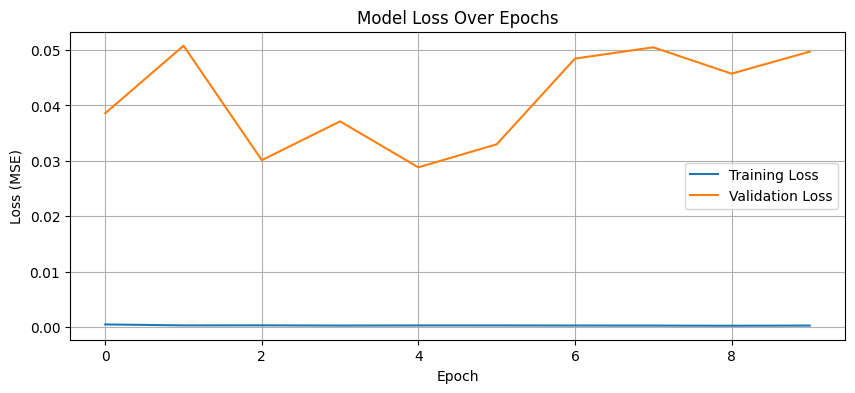

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
model_multi_ttf2 | MAE:  4.791  MSE: 34.673  RMSE:  5.888  R²:  0.301


Label       MAE        MSE      RMSE  \
0  softcaped_prediction_single_featureLSTM  5.109371  40.718421  6.381099   
1        log_prediction_single_featureLSTM  5.573143  43.939569  6.628693   
2                        model_base_stress  5.989234  60.056969  7.749643   
3                        model_17_features  4.856891  35.247534  5.936963   
4                 model_11feature_selected  5.573143  43.939569  6.628693   
5                            model_multi10  5.575670  52.187351  7.224081   
6                             model_multi7  5.690019  55.147832  7.426159   
7                  model_multi_ttf_related  6.170526  60.695343  7.790722   
8                         model_multi_top4  4.885255  36.345825  6.028750   
9                         model_multi_ttf2  4.790936  34.672640  5.888348   

         R2 cutoff_date  
0  0.179699  2023-03-31  
1  0.114807  2023-03-31  
2 -0.209889  2023-03-31  
3  0.308658  2023-03-31  
4  0.114807  2023-03-30  
5 -0.051350  2023-03-31  
6 -0.110991  2023-03-31  
7 -0.222750  2023-03-31  
8  0.267788  2023-03-01  
9  0.301496  2023-03-31

In [95]:
#@title Selecting top 2 (TTF_Price and TTFMc1_Close)
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_ttf2 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_ttf2.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_ttf2 = model_multi_ttf2.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_ttf2)


# After model prediction (in scaled space)
y_pred_scaled = model_multi_ttf2.predict(X_test)

# Inverse just the price component
y_pred_multi_ttf2 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=2)
y_test_multi_ttf2 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=2)

evaluation_metrics(y_test_multi_ttf2,y_pred_multi_ttf2, label = 'model_multi_ttf2', cutoff_date = '2023-03-31', results_df = results_df)



In [96]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_multi_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

# import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_multi_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_multi_ttf2,
    y_true_inv=y_test_multi_ttf2,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_model_multi_ttf2_train_2024',
    # save_path=save_path # Commented out to prevent image export error
)
# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_model_multi_ttf2_train_2023_03"))

X_train shape: (4140, 365, 2)
X_test shape: (1289, 365, 2)
y_train shape: (4140,)
y_test shape: (1289,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.6393e-04 - mae: 0.0155 - mape: 1119.3384 - rmse: 0.0204 - val_loss: 0.0030 - val_mae: 0.0328 - val_mape: 22.3388 - val_rmse: 0.0545 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 8.8429e-05 - mae: 0.0069 - mape: 5224.4458 - rmse: 0.0094 - val_loss: 0.0035 - val_mae: 0.0360 - val_mape: 24.3229 - val_rmse: 0.0590 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.5668e-05 - mae: 0.0064 - mape: 123.4798 - rmse: 0.0087 - val_loss: 0.0029 - val_mae: 0.0330 - val_mape: 23.0497 - val_rmse: 0.0537 - learning_rate: 0.0010
Epoch 4/50
115/117 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.2895e-05 - mae: 0.0062 - mape: 4615.0928 - rmse: 0.0085
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - l

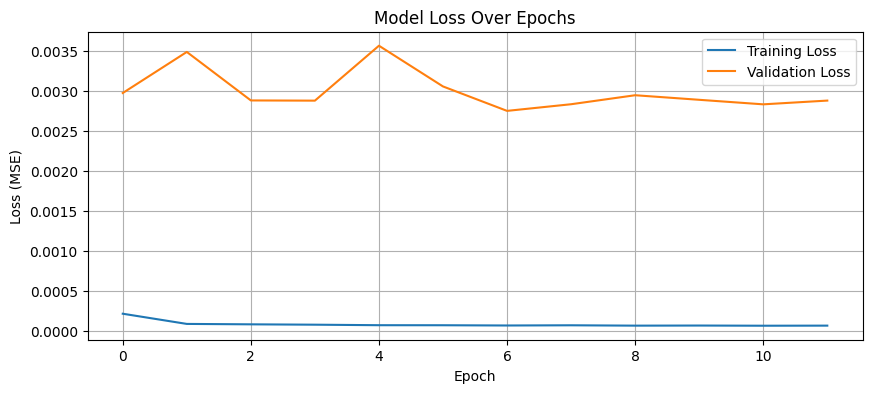

In [97]:
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_ttf_TTFMc1_2021 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_ttf_TTFMc1_2021.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_ttf_TTFMc1_2021 = model_ttf_TTFMc1_2021.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_ttf_TTFMc1_2021)




In [98]:
model_ttf_TTFMc1_2021.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 365, 64)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 365, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,805 (346.90 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,204 (231.27 KB)

In [100]:
#@title Evaluate the result by inverse y_test and y_pred during  war and post war periods

# --- Step 1: Make predictions ---
y_pred_scaled = model_ttf_TTFMc1_2021.predict(X_test)

# --- Step 2: Inverse-transform prediction and ground truth ---
y_pred_inv_ttf_TTFMc1_2021 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=2)
y_test_inv_ttf_TTFMc1_2021 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=2)

# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_multi_features.index[forecast_start_idx : forecast_start_idx + len(y_test_inv_ttf_TTFMc1_2021)]

y_pred_series = pd.Series(y_pred_inv_ttf_TTFMc1_2021, index=forecast_dates)
y_test_series = pd.Series(y_test_inv_ttf_TTFMc1_2021, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='TTF_TTFMc1_2021_War', cutoff_date = '2021-12-31', results_df=results_df
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='TTF_TTFMc1_2021_PostWar', cutoff_date = '2021-12-31', results_df=results_df
)



41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
TTF_TTFMc1_2021_War | MAE: 39.623  MSE: 2924.676  RMSE: 54.080  R²:  0.090
TTF_TTFMc1_2021_PostWar | MAE:  4.921  MSE: 35.623  RMSE:  5.968  R²:  0.282


In [101]:
evaluation_metrics(
    y_test_inv_ttf_TTFMc1_2021, y_pred_inv_ttf_TTFMc1_2021,
    label='TTF_TTFMc1_2021_total_testperiod', cutoff_date = '2021-12-31', results_df=results_df
)

evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='TTF_TTFMc1_2021_War', cutoff_date = '2021-12-31', results_df=results_df
)

evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='TTF_TTFMc1_2021_PostWar', cutoff_date = '2021-12-31', results_df=results_df
)



TTF_TTFMc1_2021_total_testperiod | MAE: 17.170  MSE: 1055.421  RMSE: 32.487  R²:  0.555
TTF_TTFMc1_2021_War | MAE: 39.623  MSE: 2924.676  RMSE: 54.080  R²:  0.090
TTF_TTFMc1_2021_PostWar | MAE:  4.921  MSE: 35.623  RMSE:  5.968  R²:  0.282


Label        MAE          MSE  \
0   softcaped_prediction_single_featureLSTM   5.109371    40.718421   
1         log_prediction_single_featureLSTM   5.573143    43.939569   
2                         model_base_stress   5.989234    60.056969   
3                         model_17_features   4.856891    35.247534   
4                  model_11feature_selected   5.573143    43.939569   
5                             model_multi10   5.575670    52.187351   
6                              model_multi7   5.690019    55.147832   
7                   model_multi_ttf_related   6.170526    60.695343   
8                          model_multi_top4   4.885255    36.345825   
9                          model_multi_ttf2   4.790936    34.672640   
10                      TTF_TTFMc1_2021_War  39.623434  2924.676280   
11                  TTF_TTFMc1_2021_PostWar   4.920846    35.622973   
12         TTF_TTFMc1_2021_total_testperiod  17.170402  1055.420688   
13                      TTF_TTFMc1_2021_War  39.623434  2924.676280   
14                  TTF_TTFMc1_2021_PostWar   4.920846    35.622973   

         RMSE        R2 cutoff_date  
0    6.381099  0.179699  2023-03-31  
1    6.628693  0.114807  2023-03-31  
2    7.749643 -0.209889  2023-03-31  
3    5.936963  0.308658  2023-03-31  
4    6.628693  0.114807  2023-03-30  
5    7.224081 -0.051350  2023-03-31  
6    7.426159 -0.110991  2023-03-31  
7    7.790722 -0.222750  2023-03-31  
8    6.028750  0.267788  2023-03-01  
9    5.888348  0.301496  2023-03-31  
10  54.080276  0.090061  2021-12-31  
11   5.968498  0.282351  2021-12-31  
12  32.487239  0.554717  2021-12-31  
13  54.080276  0.090061  2021-12-31  
14   5.968498  0.282351  2021-12-31

In [102]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_multi_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

# import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_multi_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_inv_ttf_TTFMc1_2021,
    y_true_inv=y_test_inv_ttf_TTFMc1_2021,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_ttf_TTFMc1_2021',
    # save_path=save_path # Commented out to prevent image export error
)

# Compute metrics
mae_war = mean_absolute_error(y_test_series[war_mask], y_pred_series[war_mask])
r2_war = r2_score(y_test_series[war_mask], y_pred_series[war_mask])

mae_postwar = mean_absolute_error(y_test_series[postwar_mask], y_pred_series[postwar_mask])
r2_postwar = r2_score(y_test_series[postwar_mask], y_pred_series[postwar_mask])


# Add shaded boxes
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=forecast_dates[-1],
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)

# Add annotations
fig.add_annotation(
    text=f"War Period<br>MAE: {mae_war:.2f}<br>R²: {r2_war:.2f}",
    x="2022-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightSalmon",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.add_annotation(
    text=f"Post-War Period<br>MAE: {mae_postwar:.2f}<br>R²: {r2_postwar:.2f}",
    x="2024-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_ttf_TTFMc1_2021"))

In [103]:
# Save and reload the model
save_model_and_history(model_ttf_TTFMc1_2021, history_ttf_TTFMc1_2021, '/content/drive/My Drive/BKW/Models', model_name='TTF_lstm_model_ttf_TTFMc1_2021')

# load the model
# model_loaded, history_loaded = load_model_and_history('/content/drive/My Drive/BKW/Models', model_name='TTF_lstm_model_ttf_TTFMc1_2021')

✅ Model saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_ttf_TTFMc1_2021.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_ttf_TTFMc1_2021_history.pkl


X_train shape: (4595, 365, 1)
X_test shape: (834, 365, 1)
y_train shape: (4595, 1)
y_test shape: (834, 1)
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0016 - mae: 0.0218 - mape: 2762.0037 - rmse: 0.0373 - val_loss: 0.0450 - val_mae: 0.1600 - val_mape: 65.4305 - val_rmse: 0.2122 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 3.8281e-04 - mae: 0.0112 - mape: 1108.0247 - rmse: 0.0195 - val_loss: 0.0575 - val_mae: 0.1789 - val_mape: 76.0669 - val_rmse: 0.2397 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.6323e-04 - mae: 0.0096 - mape: 183.1971 - rmse: 0.0162 - val_loss: 0.0418 - val_mae: 0.1541 - val_mape: 62.2740 - val_rmse: 0.2045 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.8268e-04 - mae: 0.0096 - mape: 197.9064 - rmse: 0.0167 - val_loss: 0.0312 - val_mae: 0.1272 - val_mape: 43.3985 - val_rmse: 0.1765 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━

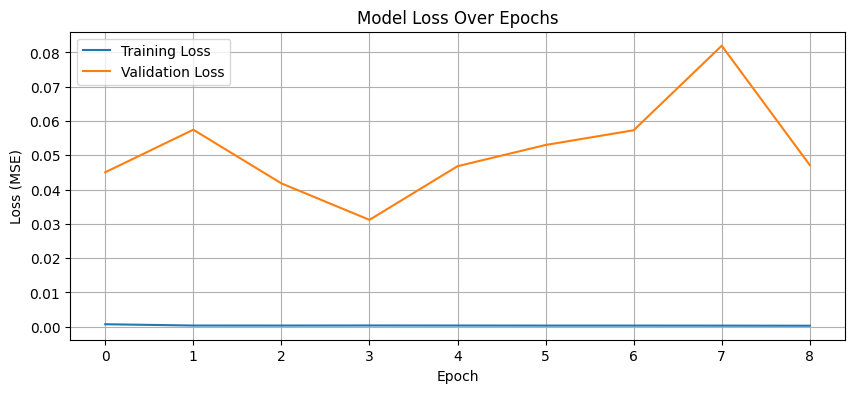

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
model_base_single | MAE:  5.556  MSE: 43.663  RMSE:  6.608  R²:  0.120


Label        MAE          MSE  \
0   softcaped_prediction_single_featureLSTM   5.109371    40.718421   
1         log_prediction_single_featureLSTM   5.573143    43.939569   
2                         model_base_stress   5.989234    60.056969   
3                         model_17_features   4.856891    35.247534   
4                  model_11feature_selected   5.573143    43.939569   
5                             model_multi10   5.575670    52.187351   
6                              model_multi7   5.690019    55.147832   
7                   model_multi_ttf_related   6.170526    60.695343   
8                          model_multi_top4   4.885255    36.345825   
9                          model_multi_ttf2   4.790936    34.672640   
10                      TTF_TTFMc1_2021_War  39.623434  2924.676280   
11                  TTF_TTFMc1_2021_PostWar   4.920846    35.622973   
12         TTF_TTFMc1_2021_total_testperiod  17.170402  1055.420688   
13                      TTF_TTFMc1_2021_War  39.623434  2924.676280   
14                  TTF_TTFMc1_2021_PostWar   4.920846    35.622973   
15                        model_base_single   5.555594    43.663150   

         RMSE        R2 cutoff_date  
0    6.381099  0.179699  2023-03-31  
1    6.628693  0.114807  2023-03-31  
2    7.749643 -0.209889  2023-03-31  
3    5.936963  0.308658  2023-03-31  
4    6.628693  0.114807  2023-03-30  
5    7.224081 -0.051350  2023-03-31  
6    7.426159 -0.110991  2023-03-31  
7    7.790722 -0.222750  2023-03-31  
8    6.028750  0.267788  2023-03-01  
9    5.888348  0.301496  2023-03-31  
10  54.080276  0.090061  2021-12-31  
11   5.968498  0.282351  2021-12-31  
12  32.487239  0.554717  2021-12-31  
13  54.080276  0.090061  2021-12-31  
14   5.968498  0.282351  2021-12-31  
15   6.607810  0.120376  2023-03-31

In [105]:
#@title Single feature base model
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_multi_features[['TTF_Price']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_multi_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_base_single = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_base_single.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_model_base_single = model_base_single.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_model_base_single)


# After model prediction (in scaled space)
y_pred_scaled = model_base_single.predict(X_test)

# Inverse just the price component
y_test_base_single = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_base_single = scaler.inverse_transform(y_pred_scaled)


evaluation_metrics(y_test_base_single,y_pred_base_single, label = 'model_base_single', cutoff_date = '2023-03-31', results_df = results_df)



41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step
                | MAE: 17.646  MSE: 1130.776  RMSE: 33.627  R²:  0.523


In [ ]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_multi_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

# import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_multi_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_inv,
    y_true_inv=y_test_inv,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_model_single_feature',
    # save_path=save_path # Commented out to prevent image export error
)
# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by Multi_layer_lstm_model_single_feature"))

In [108]:
results_df.drop_duplicates(inplace=True)
results_df.reset_index(drop=True, inplace=True)

In [109]:
# Save to CSV
results_df.to_csv('/content/drive/My Drive/BKW/reports/test_results_TTF_LSTM_model.csv', index=False)